In [19]:
import numpy as np
import os

In [20]:
num_epochs = 10
batch_size =500
decay_steps = 500
decay_rate = 0.98
starter_learning_rate = 1e-4
train_ratio = 0.99
reg_constant = 0.01
drop_out_rate = 0.5
# load the data
train_path = './slice_sample'

In [21]:
data = []
for f in os.listdir(train_path):
    item = np.load(train_path + '/' + f,'r', True)
    data.append(item)

print(len(os.listdir(train_path)))


data = np.array(data) # shape of (2, 32, 32)
data = np.moveaxis(data, 1, -1) # move the axis to the last, then the shape is (32, 32, 2)
indx = int(0.8*len(data))
train = data[:indx]
val = data[indx:]

#normalisation
dat_mean = np.mean(train[:,:,:,0] ,axis=0, keepdims=True)
dat_std = np.std(train[:,:,:,0], axis=0, keepdims=True)
X_train = ((train[:,:,:,0]-dat_mean)/dat_std).reshape(-1,32,32,1)

y_train = train[:,:,:,1].reshape(-1,32,32,1)*10e2
X_val = ((val[:,:,:,0]-dat_mean)/dat_std).reshape(-1,32,32,1)

y_val = val[:,:,:,1].reshape(-1,32,32,1)*10e2
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

5320
(4256, 32, 32, 1) (4256, 32, 32, 1) (1064, 32, 32, 1) (1064, 32, 32, 1)


In [22]:
import tensorflow as tf

def RES(input):
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def SE(input):
    x = tf.keras.layers.GlobalAveragePooling2D()(input)

    y = tf.keras.layers.Dense(64/16, activation='relu')(x)
    z = tf.keras.layers.Dense(64, activation='sigmoid')(y)
    w = tf.keras.layers.Multiply()([input, z])
    return input + w

def SE_RESNET(input):
    x = RES(input)
    x = SE(x)
    return x

def build_model():
    inputs = tf.keras.Input(shape = (32, 32, 1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D((2,2), 2, "same")(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2,2), 2, "same")(x)

    x = SE_RESNET(x)
    x = SE_RESNET(x)
    x = SE_RESNET(x)
    x = SE_RESNET(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu')(x)

    x = tf.keras.layers.Conv2D(1, (3,3), strides=1, padding='same', activation='relu')(x)
    model = tf.keras.Model(inputs, x)
    return model

model = build_model()




In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_11[0][0]']              
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 64)   18496       ['max_pooling2d_2[0][0]']        
                                                                                            

In [24]:
# metric: R2
def r_square(y_true, y_pred):
    SS_res =  tf.keras.backend.sum(tf.keras.backend.square(y_true-y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

# loss function: MSE
def mse(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))

# learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=mse,
                metrics=[r_square])

# train the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
9/9 [==============================] - 23s 2s/step - loss: 0.0201 - r_square: -2.6105 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.0069 - r_square: -0.3005 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 3/10
9/9 [==============================] - 21s 2s/step - loss: 0.0056 - r_square: -0.0621 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 4/10
9/9 [==============================] - 19s 2s/step - loss: 0.0055 - r_square: -0.0339 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.0055 - r_square: -0.0272 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 6/10
9/9 [==============================] - 18s 2s/step - loss: 0.0054 - r_square: -0.0242 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 7/10
9/9 [==============================] - 19s 2s/step - loss: 0.0054 - r_square: -0.0224 - val_loss: 0.0050 - val_r_square: -0.0208
Epoch 8/10
9/9 [====

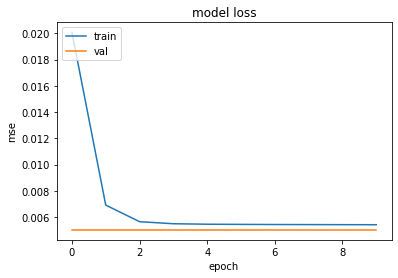

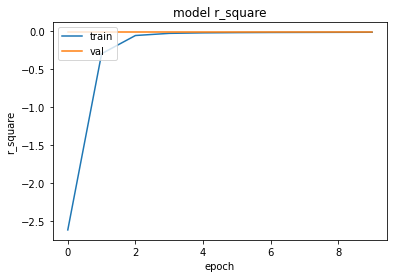

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['r_square'])
plt.plot(history.history['val_r_square'])
plt.title('model r_square')
plt.ylabel('r_square')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()